In [615]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV

import warnings
import numpy as np
from statsmodels.stats.proportion import proportions_ztest

from google.colab import auth
from google.colab import drive
auth.authenticate_user()

drive.mount('/content/gdrive')
path = '/content/gdrive/My Drive/Colab Notebooks/prj3/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).



# Q) 성능 metric 설정 (Accuancy, F-1 Score, Recall)

####A) 선정하는 로직을 짜보는 것 (이탈 유저가 적은 경우나 이런저런 경우를 확인) -> 추가적인 대책을 세울 수 있는 경우 범위를 더 넓게 잡아주는 것도 방법이다





# Q) 제품 4개의 경우를 포함하냐 포함하지 않냐? (모델 자체 성능 vs overfitting 문제)

####A) 그냥 써라

In [616]:
warnings.filterwarnings("ignore")
df = pd.read_csv(path + 'Bank Customer Churn Prediction.csv')
df = df[df['country'] == 'Germany']
print(df.head(2))

    customer_id  credit_score  country  gender  age  tenure    balance  \
7      15656148           376  Germany  Female   29       4  115046.74   
15     15643966           616  Germany    Male   45       3  143129.41   

    products_number  credit_card  active_member  estimated_salary  churn  
7                 4            1              0         119346.88      1  
15                2            0              1          64327.26      0  


#### 이상치 처리 (isolation forest + Z-score)



In [617]:
df['gender'] = df['gender'].apply(lambda x: 1 if x == 'Male' else 0)
df.drop(columns = ['customer_id', 'country'], inplace = True)
df.shape

(2509, 10)

In [618]:
# ML 방식을 사용하여 이상치 열 생성
model = IsolationForest(contamination=0.1)  # 이상치 비율을 나타내는 매개변수
df['outlier'] = model.fit_predict(df)

# 통계적 방식을 사용하여 Z-score 열 생성
df['z'] = (df['credit_score'] - df['credit_score'].mean()) / df['credit_score'].std()

# 이상치 조건을 사용하여 이상치 여부 결정
df['is_outlier'] = (df['outlier'] == -1) & (abs(df['z']) > 3)

# 결과를 기준으로 df를 업데이트
df = df[df['is_outlier'] != True]
df.drop(columns = ['outlier', 'z', 'is_outlier'], inplace = True)

# outlier 제거 완료
df

,credit_score,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
7,376,0,29,4,115046.74,4,1,0,119346.88,1
15,616,1,45,3,143129.41,2,0,1,64327.26,0
16,653,1,58,1,132602.88,1,1,0,5097.67,1
26,756,1,36,2,136815.64,1,1,1,170041.95,0
28,574,0,43,3,141349.43,1,1,1,100187.43,0
...,...,...,...,...,...,...,...,...,...,...
9982,655,0,46,7,137145.12,1,1,0,115146.40,1
9984,602,1,35,7,90602.42,2,1,1,51695.41,0
9986,673,1,47,1,183579.54,2,0,1,34047.54,0
9990,714,1,33,3,35016.60,1,1,0,53667.08,0


### 데이터 그룹만들고 전처리

In [619]:
def make_group(df, col, bins, labels) :
  return pd.cut(df[col], bins=bins, labels=labels)

In [620]:
#age_group
# 결혼 및 아이의 독립을 기준으로 나누기
df['age_group'] = make_group(df, 'age', [18, 32, 56, 84], ['single', 'married', 'senior'])
df.drop(columns = 'age', inplace = True)

# 베이비붐 세대: 46년생 ~ 64년생
# X세대: 65년생 ~ 80년생
# 밀레니얼 세대 (Y세대): 81년생 ~ 95년생
# Z세대: 96년생 ~ 12년생
# df['age_group'] = make_group(df, 'age', [18, 27, 42, 58, 84], ['Z', 'millennial', 'X', 'baby boom'])
# df.drop(columns = 'age', inplace = True)


# 위 두 기준을 합쳐서 더욱 세분화
# df['age_group'] = make_group(df, 'age', [18, 32, 42, 58, 84], ['Z_single', 'mil_married', 'X_married', 'baby_boom'])
# df.drop(columns = 'age', inplace = True)

#---------------------------------------------------------------------------------------------------------------


# salary_group : 통계값으로 나누기
# df['salary_group'] = make_group(df, 'estimated_salary', [11.58, 51113.14, 102184.66, 151167.94, 199992.48], ['75', '50', '25', '0'])
# df.drop(columns = 'estimated_salary', inplace = True)

#---------------------------------------------------------------------------------------------------------------

# balance
# df['balance_group'] = make_group(df, 'balance', [27288.43, 102773.2, 119714.25, 137648.41, 214346.96], ['75', '50', '25', '0'])
# df.drop(columns = 'balance', inplace = True)

#---------------------------------------------------------------------------------------------------------------
# FICO 표준 평가 방법 [350, 579, 669, 739, 799, 850] 사용
# df['credit_group'] = make_group(df, 'credit_score', [350, 579, 669, 739, 799, 850], ['F', 'D', 'C', 'B', 'A'])
# df.drop(columns = 'credit_score', inplace = True)

#---------------------------------------------------------------------------------------------------------------
#credit score + credit_card 그룹
# FICO 표준 평가 방법 [350, 579, 669, 739, 799, 850]을 modify해서 사용
# df['credit_group'] = make_group(df, 'credit_score', [350, 579, 669, 739, 850], ['D', 'C', 'B', 'A'])
# df['credit_group'] = df['credit_group'].astype(str)
# df['combined_group'] = df['credit_group'] + df['credit_card'].astype(str)
# df.drop(columns = ['credit_score', 'credit_card', 'credit_group'], inplace = True)
df.shape

(2507, 10)

In [621]:
df.head(2)

,credit_score,gender,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,age_group
7,376,0,4,115046.74,4,1,0,119346.88,1,single
15,616,1,3,143129.41,2,0,1,64327.26,0,married


In [622]:
# 스케일링할 변수 선택
columns_to_scale = ['tenure', 'balance', 'estimated_salary', 'credit_score']
# one-hot encoding할 변수 선택
columns_to_encode = ['age_group', 'products_number']
# columns_to_encode = ['products_number', 'age_group', 'salary_group', 'combined_group', 'balance_group']

# StandardScaler 객체 생성
scaler = StandardScaler()

# 선택한 변수들에 대해 스케일링을 수행
df_scaled = df.copy()  # 데이터프레임 복사
df_scaled[columns_to_scale] = scaler.fit_transform(df_scaled[columns_to_scale])

# one-hot encoding 수행
df_encoded = pd.get_dummies(df_scaled, columns=columns_to_encode)

# one-hot encoding 결과 확인
df_encoded.head(2)

,credit_score,gender,tenure,balance,credit_card,active_member,estimated_salary,churn,age_group_single,age_group_married,age_group_senior,products_number_1,products_number_2,products_number_3,products_number_4
7,-2.818389,0,-0.345050,-0.172883,1,0,0.313607,1,1,0,0,0,0,0,1
15,-0.364893,1,-0.685886,0.866725,0,1,-0.630825,0,0,1,0,0,1,0,0


In [623]:
# 모델 정의
model = DecisionTreeClassifier()

param_grid = param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 2, 3, 4],
    'min_samples_split': [1, 2, 3, 4],
}

Classifiers = GridSearchCV(model, param_grid, cv=5, scoring='recall')

In [624]:
# 데이터를 피처와 타겟 변수로 분리
feature_cols = ['products_number_2', 'age_group_single', 'products_number_1', 'active_member', 'estimated_salary']
X = df_encoded[feature_cols]
y = df_encoded['churn']

# 데이터를 훈련 세트와 테스트 세트로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 모델 학습
Classifiers.fit(X_train, y_train)
best_classifier = Classifiers.best_estimator_

print("Best parameters:", Classifiers.best_params_)

# 테스트 세트 예측
y_pred = best_classifier.predict(X_test)

Best parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2}


In [625]:
# classification report 출력
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.69      0.76       339
           1       0.53      0.74      0.62       163

    accuracy                           0.71       502
   macro avg       0.69      0.71      0.69       502
weighted avg       0.74      0.71      0.71       502



In [626]:
# 각 feature의 중요도를 Series로 변환
importance = pd.Series(best_classifier.feature_importances_, index=X.columns)

# 중요도 기준으로 내림차순 정렬
importance_sorted = importance.sort_values(ascending=False)

# 결과 출력
print(importance_sorted)

products_number_2    0.573659
age_group_single     0.238135
products_number_1    0.174104
active_member        0.012195
estimated_salary     0.001907
dtype: float64


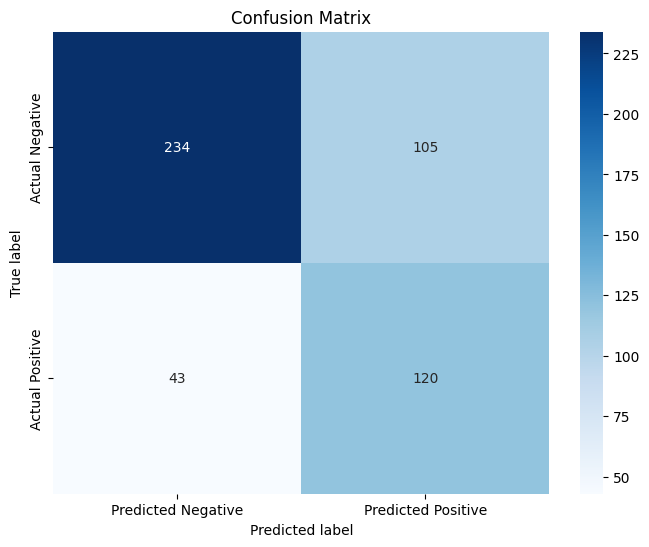

In [627]:
# Confusion Matrix 계산
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

#### 완성된 decision tree 저장

In [628]:
from sklearn.tree import export_graphviz
import graphviz

# 학습된 Decision Tree 모델에서 트리를 추출합니다.
tree = best_classifier

# 트리를 시각화합니다.
dot_data = export_graphviz(tree, out_file=None, feature_names=X.columns,
                           class_names=['Non-churn', 'Churn'], filled=True,
                           rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph.render(path + "decision_tree")  # "decision_tree.pdf" 파일로 저장됩니다.


'/content/gdrive/My Drive/Colab Notebooks/prj3/decision_tree.pdf'